In [15]:
%load_ext blackcellmagic
%load_ext autoreload
%autoreload 2

import numpy as np
import numpy.testing as npt
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from adafilt import FastBlockLMSFilter, LMSFilter
from adafilt.utils import olafilt, wgn

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Single channel

In [16]:
filterlength = 16
stepsizes = np.logspace(-1, 0, 3)
navg = 50
snr = 20
h_pri = [0, 0, 0, 0, 1, 0, 1]  # primary path impulse response
h_sec = [0, 0, 1, 0.5]
len_x = 1024

## LMSFilter

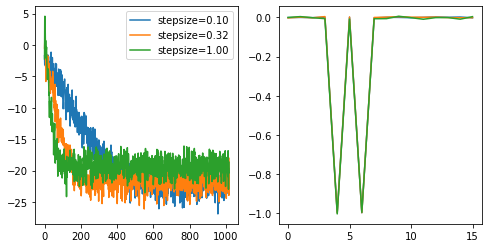

In [17]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
for stepsize in tqdm(stepsizes):
    e = 0
    w = 0
    for i in range(navg):
        # reference signal
        x = np.random.normal(0, 1, len_x)

        # desired signal with noise
        d = olafilt(h_pri, x)
        dn = d + wgn(d, snr, unit="dB")

        filt = LMSFilter(filterlength, stepsize=stepsize)

        y, _, ei, wi = filt(x[len(h_pri):], dn[len(h_pri):])
        
        e += 1/navg * 10 * np.log10(ei**2)
        w += 1/navg * wi
        
    ax[0].plot(e, label=f"stepsize={stepsize:.2f}")
    ax[1].plot(w[-1], label=f"stepsize={stepsize:.2f}")

ax[0].legend()

## LMSFilter with reference

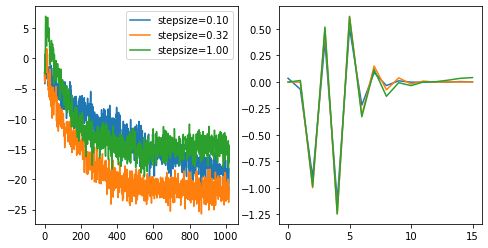

In [18]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
for stepsize in tqdm(stepsizes):
    e = 0
    w = 0
    for i in range(navg):
        # reference signal
        x = np.random.normal(0, 1, len_x)

        # desired signal with noise
        d = olafilt(h_pri, x)
        dn = d + wgn(d, snr, unit="dB")

        filt = LMSFilter(filterlength, stepsize=stepsize)

        y, u, ei, wi = filt(x[len(h_pri):], dn[len(h_pri):], h_sec, h_sec)
        
        e += 1/navg * 10 * np.log10(ei**2)
        w += 1/navg * wi
        
    ax[0].plot(e, label=f"stepsize={stepsize:.2f}")
    ax[1].plot(w[-1], label=f"stepsize={stepsize:.2f}")

ax[0].legend();

## FastBlockLMSFilter

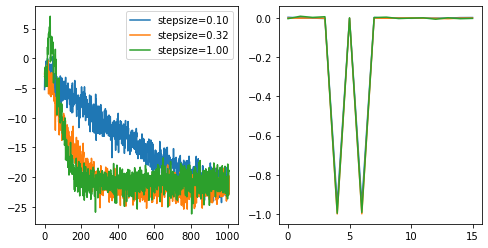

In [19]:
blocklength = filterlength
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
for stepsize in tqdm(stepsizes):
    e = 0
    w = 0
    for i in range(navg):
        # reference signal
        x = np.random.normal(0, 1, len_x)

        # desired signal with noise
        d = olafilt(h_pri, x)
        dn = d + wgn(d, snr, unit="dB")
        filt = FastBlockLMSFilter(blocklength, filterlength, stepsize=stepsize)
        y, _, ei, wi = filt(x[blocklength:], dn[blocklength:])
        
        e += 1/navg * 10 * np.log10(ei**2)
        w += 1/navg * wi
        
    ax[0].plot(e, label=f"stepsize={stepsize:.2f}")
    ax[1].plot(w[-1], label=f"stepsize={stepsize:.2f}")

ax[0].legend();

## FastBlockLMSFilter with reference

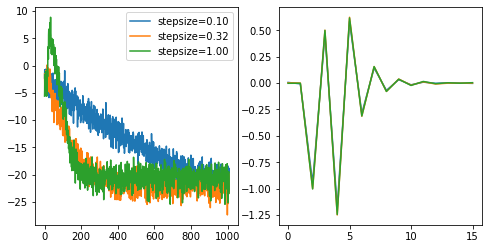

In [20]:
blocklength = filterlength
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
for stepsize in tqdm(stepsizes):
    e = 0
    w = 0
    for i in range(navg):
        # reference signal
        x = np.random.normal(0, 1, len_x)

        # desired signal with noise
        d = olafilt(h_pri, x)
        dn = d + wgn(d, snr, unit="dB")
        filt = FastBlockLMSFilter(filterlength, blocklength, stepsize=stepsize)
        y, _, ei, wi = filt(x[blocklength:], dn[blocklength:], h_sec, h_sec)
        
        e += 1/navg * 10 * np.log10(ei**2)
        w += 1/navg * wi
        
    ax[0].plot(e, label=f"stepsize={stepsize:.2f}")
    ax[1].plot(w[-1], label=f"stepsize={stepsize:.2f}")

ax[0].legend();

## FakeInterface

In [21]:
from adafilt.io import FakeInterface

buffsize = 16
buffers = 1000
signal = np.random.normal(0, 1, size=buffers * buffsize)
sim = FakeInterface(buffsize, signal, h_pri=h_pri, h_sec=h_sec)

xs = []
es = []
ds = []
us = []
ys = []

for i in range(buffers):
    y = np.random.normal(0, 1, buffsize)
    x, e, u, d = sim.playrec(y, send_signal=True)
    xs.append(x)
    es.append(e)
    ds.append(d)
    us.append(u)
    ys.append(y)

y = np.concatenate(ys)
x = np.concatenate(xs)
e = np.concatenate(es)
u = np.concatenate(us)
d = np.concatenate(ds)

assert np.all(x == signal)
assert np.allclose(d, olafilt(h_pri, x))
assert np.allclose(u, olafilt(h_sec, y))
assert np.allclose(e, u + d)

Measure primary and secondary path

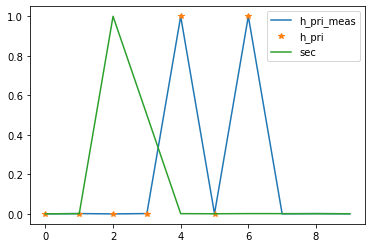

In [22]:
sim = FakeInterface(buffsize, signal, h_pri=h_pri, h_sec=h_sec)

# measure primary path
xs = []
es = []
for i in range(buffers):
    x, e, _, _ = sim.rec()
    xs.append(x)
    es.append(e)
    
xs = np.concatenate(xs)
es = np.concatenate(es)

h_pri_meas = np.fft.irfft(np.fft.rfft(es) / np.fft.rfft(xs))[:10]

# measure secondary path
#sim.reset()
ys = []
us = []
for i in range(buffers):
    y = np.random.normal(0, 1, size=buffsize)
    _, e, _, _ = sim.playrec(y, send_signal=False)
    ys.append(y)
    us.append(e)

ys = np.concatenate(ys)
us = np.concatenate(us)


h_sec_meas = np.fft.irfft(np.fft.rfft(us) / np.fft.rfft(ys))[:10]

plt.plot(h_pri_meas, label="h_pri_meas")
plt.plot(h_pri, "*", label="h_pri")
plt.plot(h_sec_meas, label="sec")
plt.legend()

npt.assert_almost_equal(h_pri_meas[:len(h_pri)], h_pri, decimal=2)
npt.assert_almost_equal(h_sec_meas[:len(h_sec)], h_sec, decimal=2)

## FxLMS

V1 usign adapt and filt

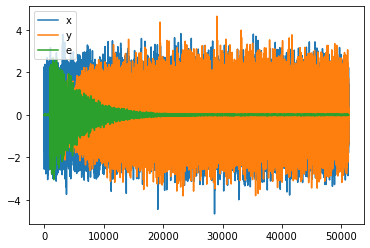

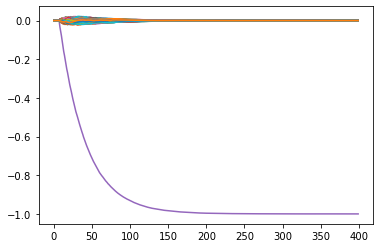

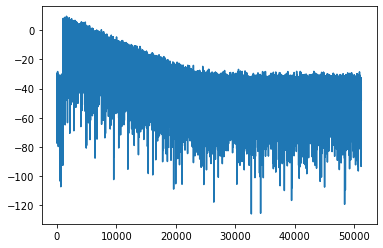

In [23]:
np.set_printoptions(precision=2)
np.random.seed(0)

h_pri = np.zeros(1024)
h_pri[-1] = 1
h_sec = np.zeros(512)
h_sec[-1] = 1

blocklength = 128
length = 512

# random signal
Nbuffs = 400
signal = np.random.normal(0, 1, size=Nbuffs * blocklength)

filt = LMSFilter(length, stepsize=0.1)
sim = FakeInterface(blocklength, signal, h_pri=h_pri, h_sec=h_sec, noise=wgn(signal, 40, 'dB'))

# error and and filtered reference stepsizest have the same delay 
h_sec_model = np.concatenate((np.zeros(blocklength), h_sec)) 

xlog = []
elog = []
wslog = []
ylog = []

zisec = np.zeros(len(h_sec_model) - 1)
y = np.zeros(blocklength)
for i in tqdm(range(Nbuffs)):
    
    x, e, u, d = sim.playrec(y)
    
    # filtered reference
    fx, zisec = olafilt(h_sec_model, x, zi=zisec)
    
    # work through the single block - sample by sample
    for i in range(blocklength):
        filt.adapt(fx[i], e[i])
        y[i] = filt.filt(x[i])
    
    xlog.append(x)
    elog.append(e)
    ylog.append(y.copy())
    wslog.append(filt.w)
    
xlog = np.concatenate(xlog)
elog = np.concatenate(elog)
ylog = np.concatenate(ylog)

plt.plot(xlog, label="x")
plt.plot(ylog, label="y")
plt.plot(elog, label="e")
plt.legend()

plt.figure()
ax = plt.plot(wslog);
#plt.legend(ax, range(length))

plt.figure()
plt.plot(10*np.log10(np.array(elog)**2))


## FastBlockFxLMS

Some necessary conditions for convergence

In [27]:
assert blocklength <= len(h_sec)
assert blocklength <= len(h_pri) - len(h_sec)
assert length > len(h_pri) - len(h_sec) - blocklength

#### Buffersize == filtersize

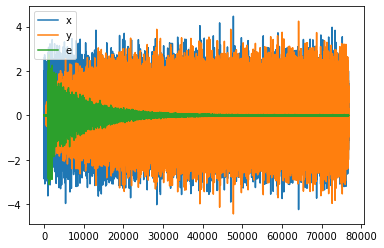

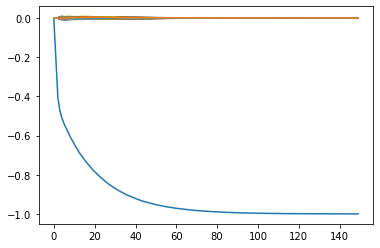

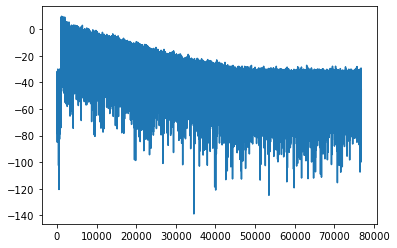

In [28]:
blocklength = 512
length = 512

Nbuffs = 150
signal = np.random.normal(0, 1, size=Nbuffs * blocklength)

filt = FastBlockLMSFilter(blocklength, length, stepsize=0.1)
sim = FakeInterface(blocklength, signal, h_pri=h_pri, h_sec=h_sec, noise=wgn(signal, 40, 'dB'))

# error and and filtered reference stepsizest have the same delay 
h_sec_model = np.concatenate((np.zeros(blocklength), h_sec)) 

xlog = []
elog = []
wslog = []
ylog = []

zisec = np.zeros(len(h_sec_model) - 1)
y = np.zeros(blocklength)
for i in tqdm(range(Nbuffs)):
    
    x, e, u, d = sim.playrec(y)

    fx, zisec = olafilt(h_sec_model, x, zi=zisec)
    
    # adapt filter
    filt.adapt(fx, e)

    # filter
    y = filt.filt(x)

    xlog.append(x)
    elog.append(e)
    ylog.append(y.copy())
    wslog.append(filt.w)
    
xlog = np.concatenate(xlog)
elog = np.concatenate(elog)
ylog = np.concatenate(ylog)
wslog = np.stack((wslog))

    
plt.plot(xlog, label="x")
plt.plot(ylog, label="y")
plt.plot(elog, label="e")
plt.legend()

plt.figure()
ax = plt.plot(wslog);
#plt.legend(ax, range(length))

plt.figure()
plt.plot(10*np.log10(np.array(elog)**2))


#### Buffersize < filtersize

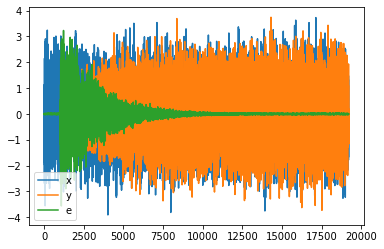

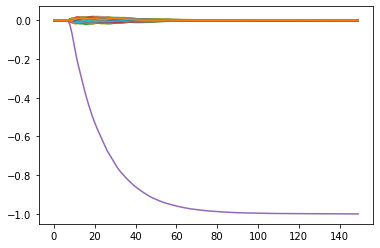

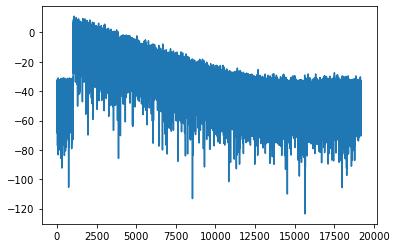

In [30]:
blocklength = 128
length = 512

Nbuffs = 150
signal = np.random.normal(0, 1, size=Nbuffs * blocklength)

filt = FastBlockLMSFilter(length, blocklength)
sim = FakeInterface(blocklength, signal, h_pri=h_pri, h_sec=h_sec, noise=wgn(signal, 40, 'dB'))

# error and and filtered reference stepsizest have the same delay 
h_sec_model = np.concatenate((np.zeros(blocklength), h_sec)) 

xlog = []
elog = []
wslog = []
ylog = []

zisec = np.zeros(len(h_sec_model) - 1)
y = np.zeros(blocklength)
for i in tqdm(range(Nbuffs)):
    
    x, e, u, d = sim.playrec(y)

    fx, zisec = olafilt(h_sec_model, x, zi=zisec)
    
    # adapt filter
    filt.adapt(fx, e)

    # filter
    y = filt.filt(x)

    xlog.append(x)
    elog.append(e)
    ylog.append(y.copy())
    wslog.append(filt.w)
    
xlog = np.concatenate(xlog)
elog = np.concatenate(elog)
ylog = np.concatenate(ylog)
wslog = np.stack((wslog))

    
plt.plot(xlog, label="x")
plt.plot(ylog, label="y")
plt.plot(elog, label="e")
plt.legend()

plt.figure()
ax = plt.plot(wslog);
#plt.legend(ax, range(length))

plt.figure()
plt.plot(10*np.log10(np.array(elog)**2))


# Static Filter

In [118]:
from adafilt.optimal import static_filter

p = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]]).T
g = np.array([[[1, 0, 0, 0],
               [0, 1, 0, 0]],
              [[1, 0, 0, 0],
               [0, 1, 0, 0]]]).T

np.real(np.fft.ifft(static_filter(p, g, squeeze=True), axis=0))

array([[-0.5, -0.5],
       [ 0. ,  0. ],
       [ 0. ,  0. ],
       [ 0. ,  0. ]])

# Wiener filter

Unconstrained and causal

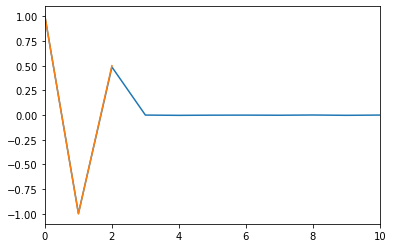

In [119]:
from adafilt.optimal import wiener_filter

h = [1, -1, 0.5]
x = np.random.random(2**14)
y = olafilt(h, x)

h_est = - np.real(np.fft.ifft(wiener_filter(x, y, 32, constrained=False)))
plt.plot(h_est, label="estimate")
plt.plot(h, label="truth")
plt.xlim(0, 10)
npt.assert_almost_equal(h, h_est[:len(h)], decimal=2)

Constrained and causal

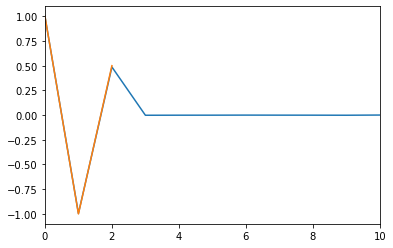

In [120]:
from adafilt.optimal import wiener_filter

h = [1, -1, 0.5]
x = np.random.random(2**14)
y = olafilt(h, x)

h_est = - np.real(np.fft.ifft(wiener_filter(x, y, 32, constrained=True)))
plt.plot(h_est, label="estimate")
plt.plot(h, label="truth")
plt.xlim(0, 10)
npt.assert_almost_equal(h, h_est[:len(h)], decimal=2)

Constrained and non-causal

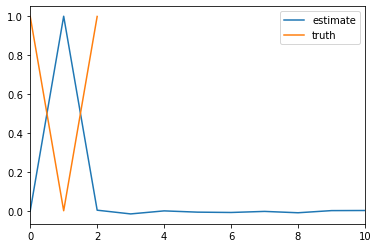

In [121]:
from adafilt.optimal import wiener_filter

h = [1, 0, 1]
x = np.random.random(2**15)
y = olafilt(h, x)

h_est = - np.real(np.fft.ifft(wiener_filter(x, y, 256, g=[0, 1], constrained=True)))
plt.plot(h_est, label="estimate")
plt.plot(h, label="truth")
plt.xlim(0, 10)
plt.legend()
npt.assert_almost_equal([0, 1, 0], h_est[:len(h)], decimal=2)

# Multichannel Wiener Filter

Single channel

In [150]:
np.real(np.fft.ifft(woptmc)).shape

(64, 1, 1)

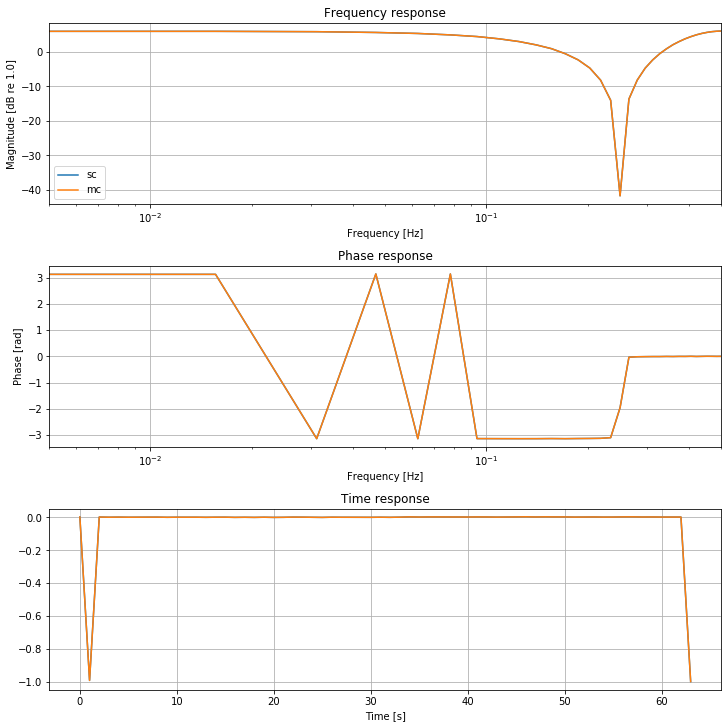

In [159]:
from adafilt.optimal import multi_channel_wiener_filter
from response import Response

n = 16
p = [1, 0, 1]
g = [0, 1, 0]
x = np.random.random(2**14)
d = olafilt(p, x)

nfilt = n * 4
wopt = wiener_filter(x, d, nfilt, g)
woptmc = multi_channel_wiener_filter(x, d, nfilt, g)

fig = Response.from_freq(1, wopt[:nfilt // 2 + 1]).plot(label="sc")
Response.from_freq(1, woptmc[:nfilt // 2 + 1].T).plot(use_fig=fig, label="mc");

npt.assert_almost_equal(wopt, woptmc[:, 0, 0])

Multichannel

/home/fhchl/Dropbox/Software/response/response.py:367: RuntimeWarning: divide by zero encountered in log10
  20 * np.log10(np.abs(freq_plotready / dbref)),


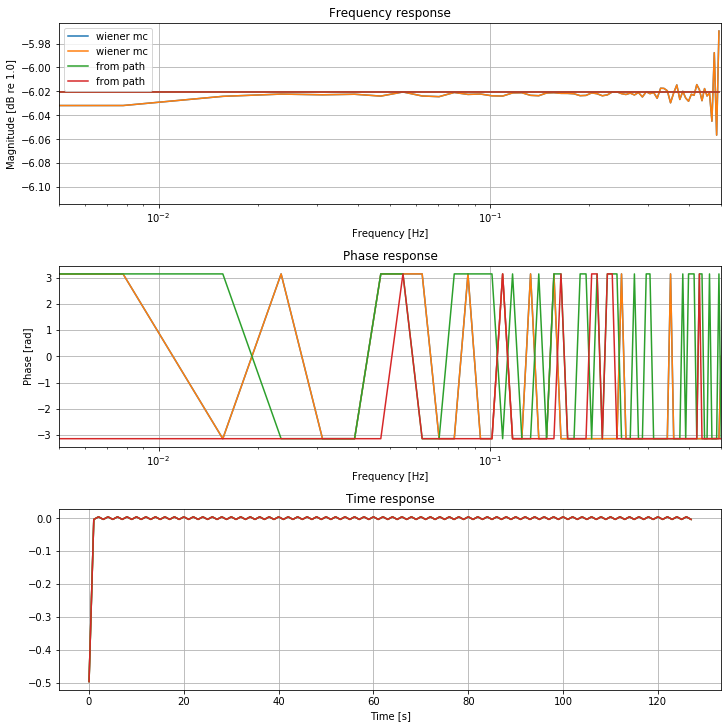

In [160]:
n = 32
Nin = 1
Nout = 2
Nmic = 3

# primary path
p = np.zeros((n, Nmic))
p[[1, 0, 1]] = 1

# secondary path
g = np.zeros((n, Nmic, Nout))
g[[0, 1]] = 1

# signal
x = np.random.normal(size=(2**18, Nin))
d = olafilt(p, x)

nfilt = 4 * n
Wsig = multi_channel_wiener_filter(x, d, nfilt, g)
Wpath = static_filter(p, g, nfilt)

fig = Response.from_freq(1, Wsig[:nfilt // 2 + 1].T).plot(label="wiener mc");
Response.from_freq(1, Wpath[:nfilt // 2 + 1].T).plot(use_fig=fig, label="from path");